In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython import display

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    f = len(frames)
    a = animation.FuncAnimation(plt.gcf(), animate, frames=f, interval=17)
    display.display(display_animation(a, default_mode='once'))

In [3]:
"""
Environment Parameters
"""
observation_space = 4
action_space = 2
env_name = 'CartPole-v0'
seed = 12

"""
Agent Parameters
"""
episodes = 1000
epsilon_init = 1.0
epsilon_decay = 0.002
epsilon_min = 0.1
gamma = 0.99

"""
Model Parameters
"""
batch_size = 128
hidden_dims = 16
activation = 'relu'
optim = 'rmsprop'
loss_func = 'mse'

In [4]:
cartpole_env = gym.make(env_name)
cartpole_env.seed(seed)
random.seed(seed)
np.random.seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [23]:
class DQN:
    def __init__(self):
        self.model = self.build_dqn()
        self.latest = None
        self.buffer = []
        
    def build_dqn(self):
        dqn = Sequential()
        dqn.add(Dense(hidden_dims, input_shape=(observation_space,)))
        dqn.add(Activation(activation))
        dqn.add(Dense(hidden_dims))
        dqn.add(Activation(activation))
        dqn.add(Dense(action_space))
        dqn.compile(optimizer=optim, loss=loss_func)
        return dqn
    
    def train(self):
        batch = random.sample(self.buffer, batch_size)
        inputs = []
        labels = []
        for sample in batch:
            s, a, r, s_p, d = sample
            inputs.append(s)
            label = self.predict(s)
            label[0][a] = r
            if not d:
                label[0][a] += gamma*np.max(self.target_predict(s_p))
            labels.append(label)
        inputs = np.squeeze(np.array(inputs), axis=1)
        labels = np.squeeze(np.array(labels), axis=1)
        self.model.fit(inputs, labels, verbose=0)
        
    def predict(self, s):
        return self.model.predict(s)
    
    def target_predict(self, s):
        return self.model.predict(s)
    
    def record_state_tuple(self, state_tuple):
        #self.latest = state_tuple
        self.buffer.append(state_tuple)

In [20]:
simple_dqn = DQN()

In [12]:
def run_episode(env, model, epsilon=0.0,
                training=False, render=False):
    total_reward = 0
    done = False
    state = np.expand_dims(env.reset(), 0)
    frames = []
    while not done:
        if render:
            frames.append(env.render(mode='rgb_array'))
        if training and random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(state)
            action = np.argmax(q_values)
        next_state, reward, done, _ = env.step(action)
        next_state = np.expand_dims(next_state, 0)
        total_reward += reward
        if training:
            exp_tuple = (state, action, reward, next_state, done)
            model.record_state_tuple(exp_tuple)
        state = next_state
    if training:
        model.train()
    epsilon -= epsilon_decay
    epsilon = max(epsilon, epsilon_min)
    if render:
        frames.append(env.render(mode='rgb_array'))
        display_frames_as_gif(frames)
    return total_reward, epsilon


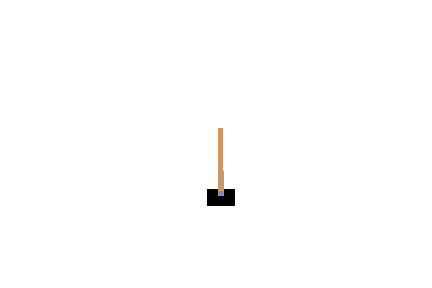
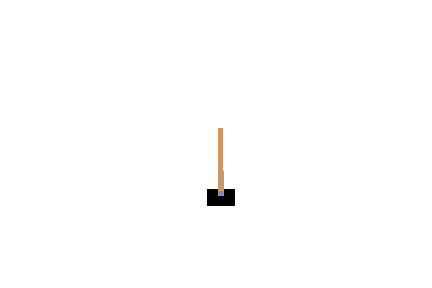
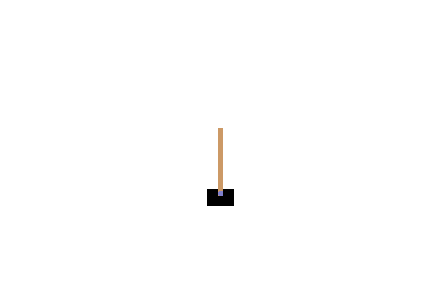
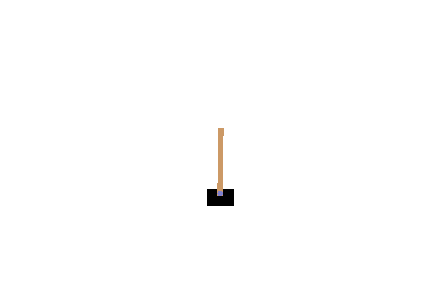
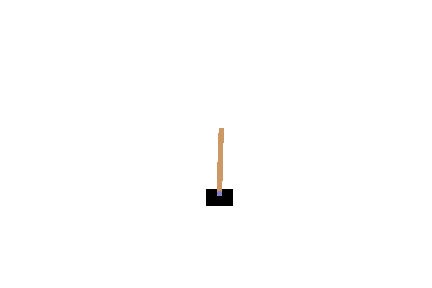
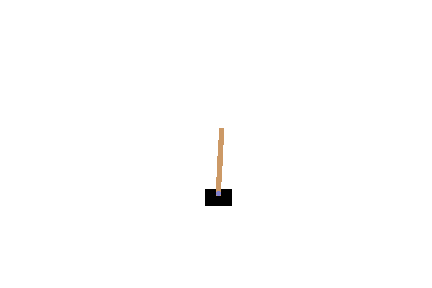
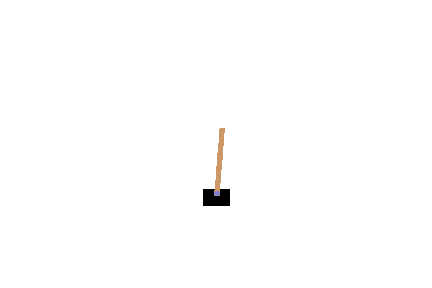
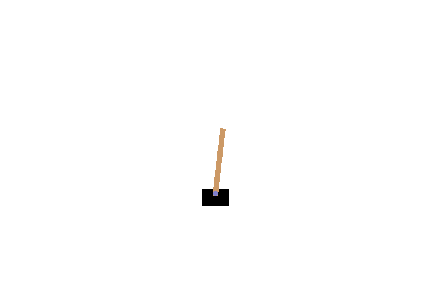
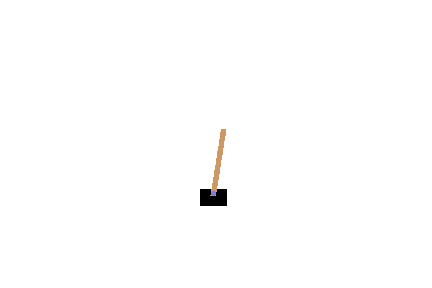
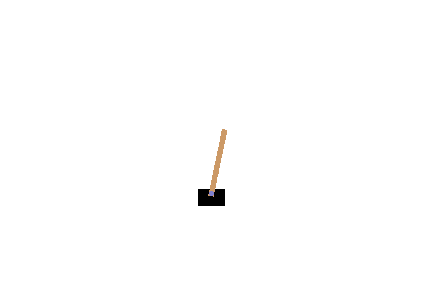
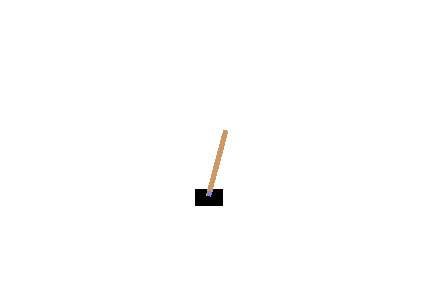

(10.0, 0.1)

In [9]:
run_episode(cartpole_env, simple_dqn, render=True)

In [13]:
def warmup_buffer(env, model):
    for _ in range(50):
        done = False
        state = np.expand_dims(env.reset(), 0)
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            next_state = np.expand_dims(next_state, 0)
            exp_tuple = (state, action, reward, next_state, done)
            model.record_state_tuple(exp_tuple)
            state = next_state

In [21]:
warmup_buffer(cartpole_env, simple_dqn)
eps = epsilon_init
sum_reward = 0
for episode in range(1, episodes+1):
    r, eps = run_episode(cartpole_env, simple_dqn, epsilon=eps,
                         training=True, render=False)
    sum_reward += r
    if episode % 10 == 0:
        avg = sum_reward / 10
        sum_reward = 0
        start = episode - 9
        print("Average total reward for episode " + \
              f"{start} through {episode}: {avg}")

Average total reward for episode 1 through 10: 20.2
Average total reward for episode 11 through 20: 21.4
Average total reward for episode 21 through 30: 19.3
Average total reward for episode 31 through 40: 17.9
Average total reward for episode 41 through 50: 20.0
Average total reward for episode 51 through 60: 19.6
Average total reward for episode 61 through 70: 23.6
Average total reward for episode 71 through 80: 20.9
Average total reward for episode 81 through 90: 23.0
Average total reward for episode 91 through 100: 20.7
Average total reward for episode 101 through 110: 21.7
Average total reward for episode 111 through 120: 20.8
Average total reward for episode 121 through 130: 26.2
Average total reward for episode 131 through 140: 17.6
Average total reward for episode 141 through 150: 19.0
Average total reward for episode 151 through 160: 14.7
Average total reward for episode 161 through 170: 14.4
Average total reward for episode 171 through 180: 16.2
Average total reward for episo


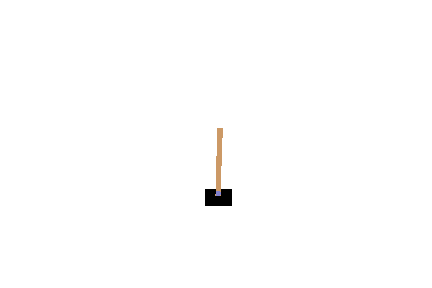
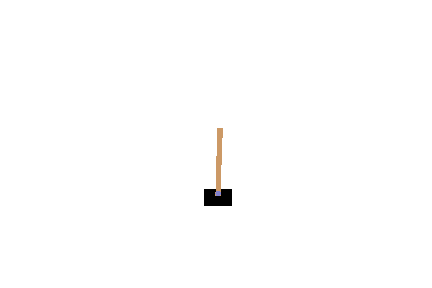
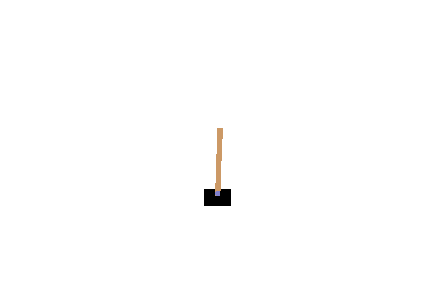
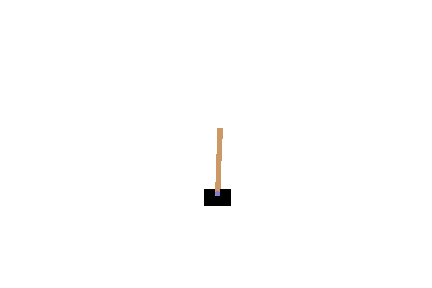
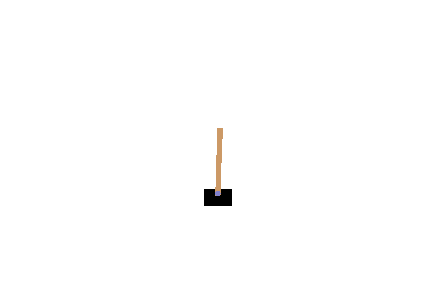
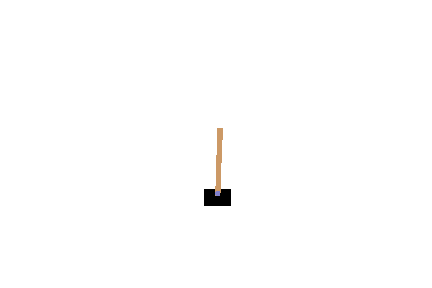
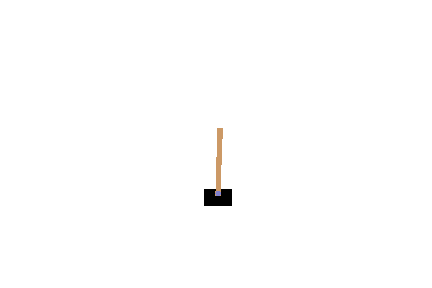
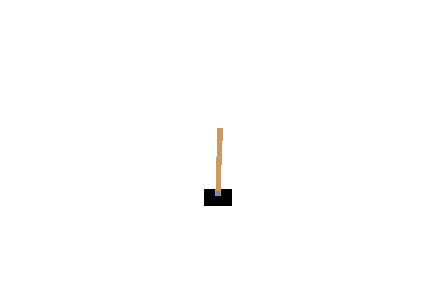
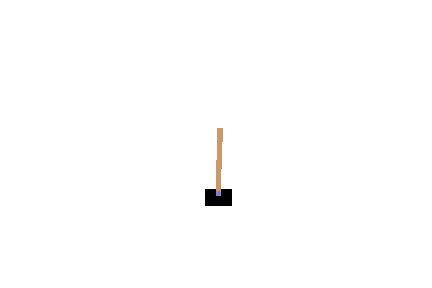
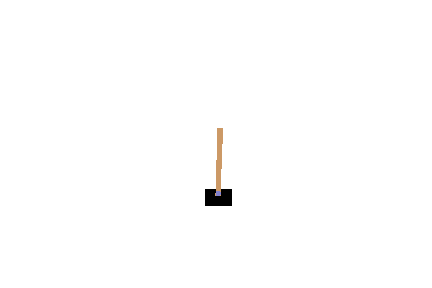
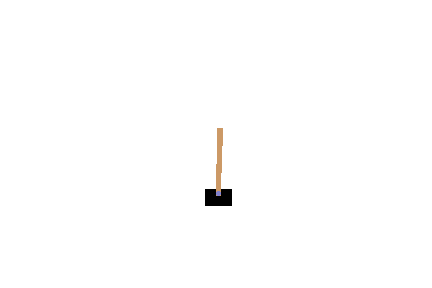
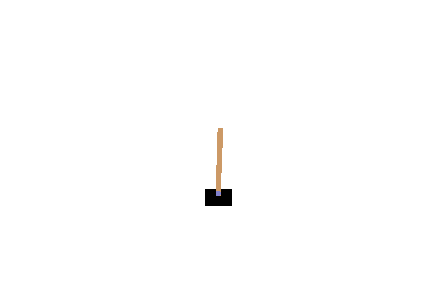
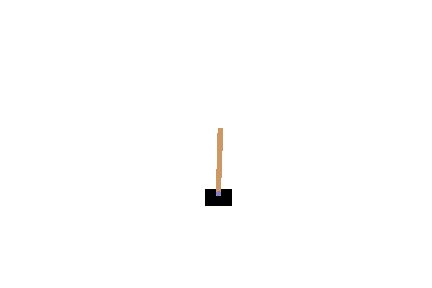
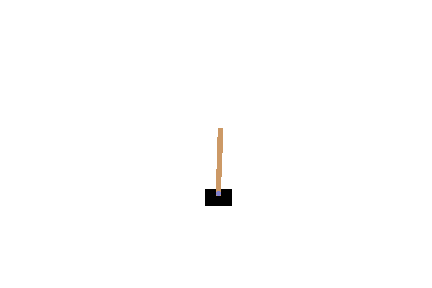
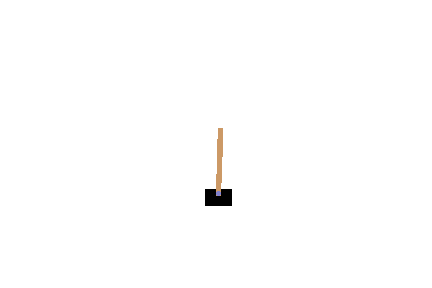
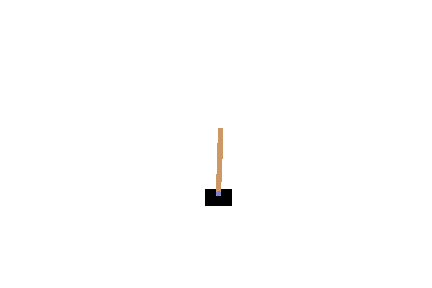
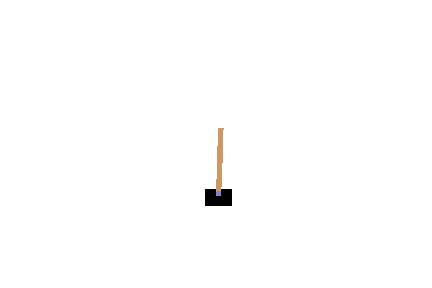
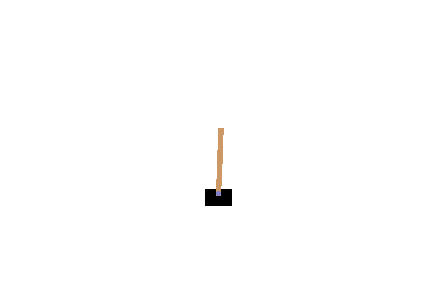
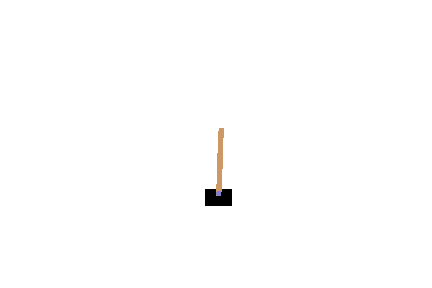
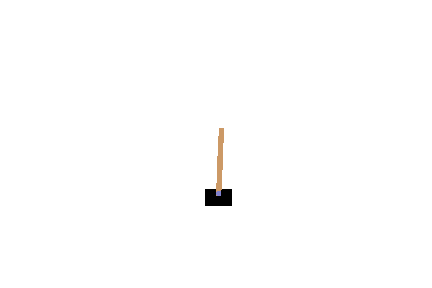
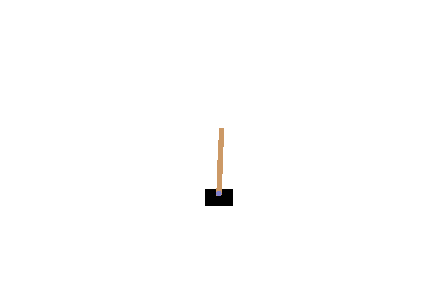
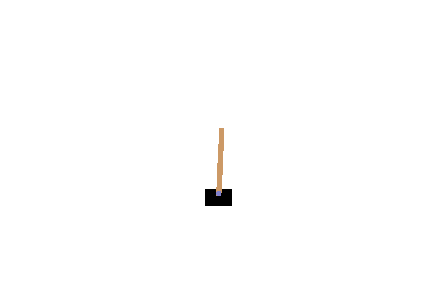
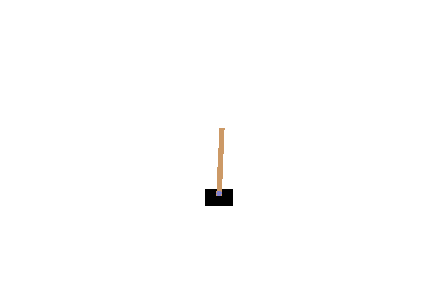
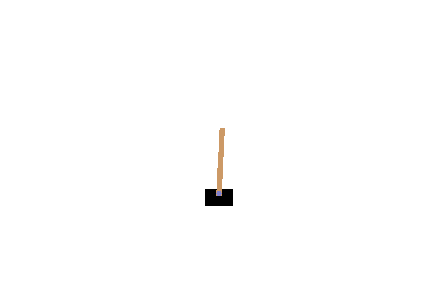
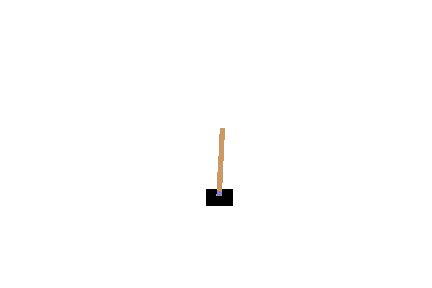
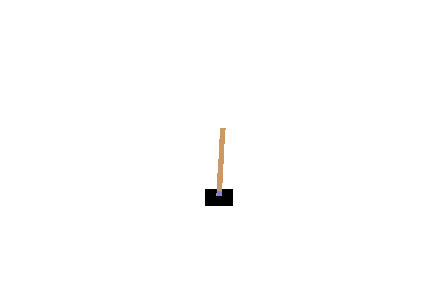
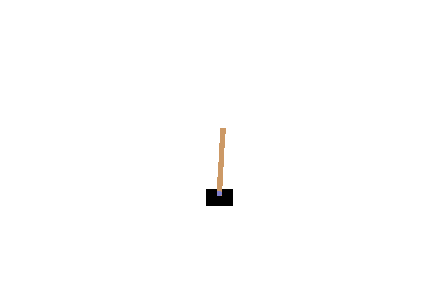
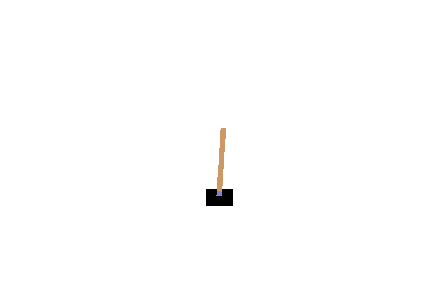
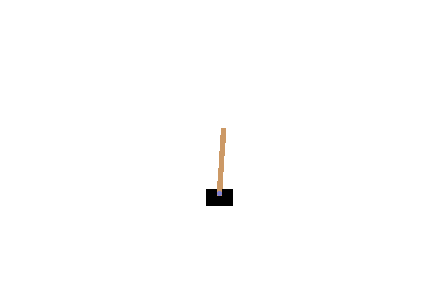
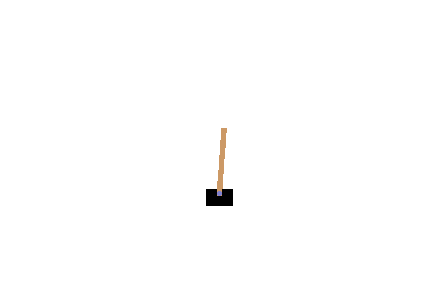
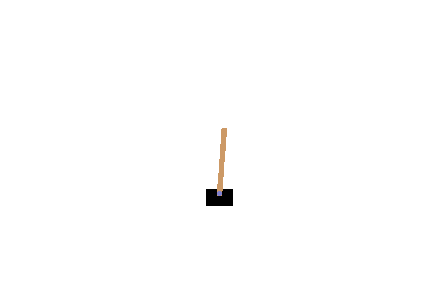
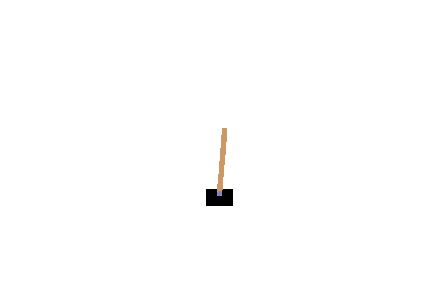
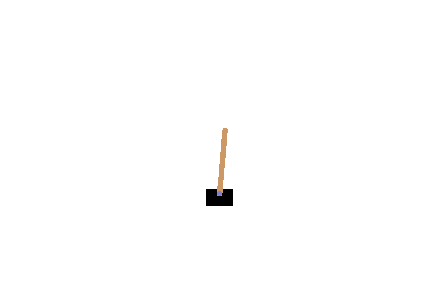
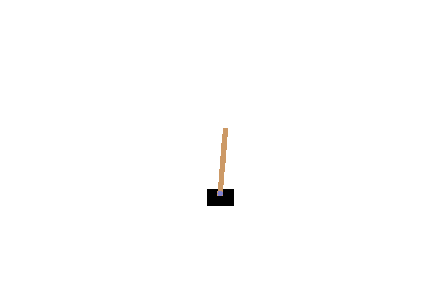
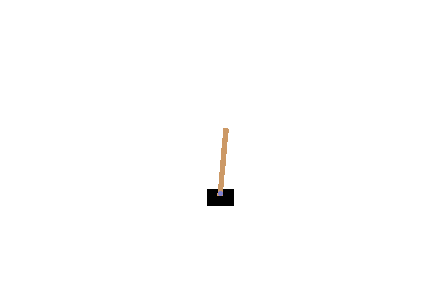
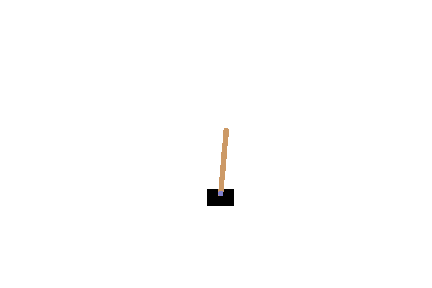
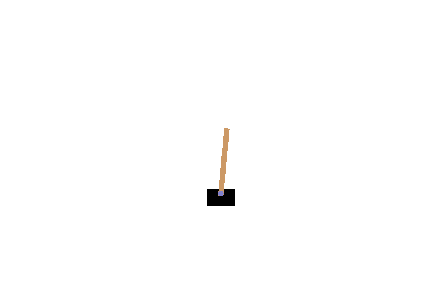
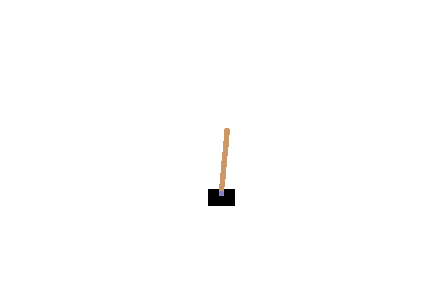
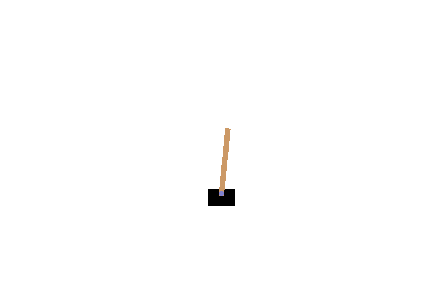
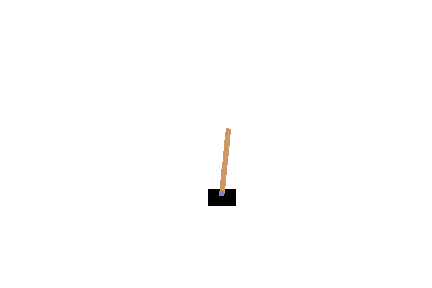
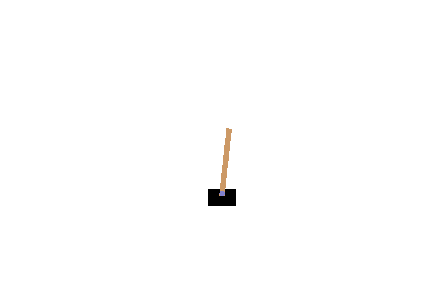
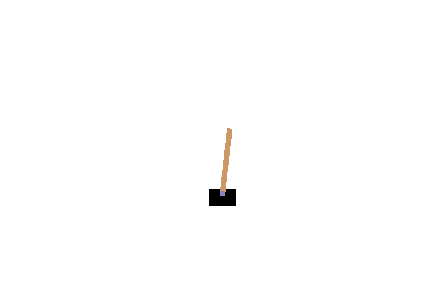
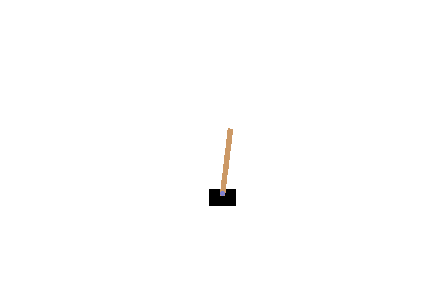
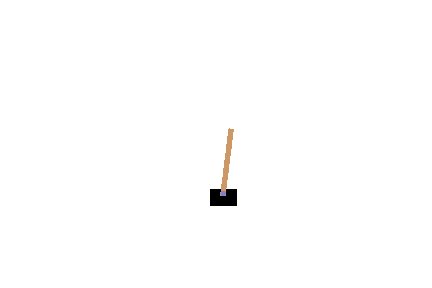
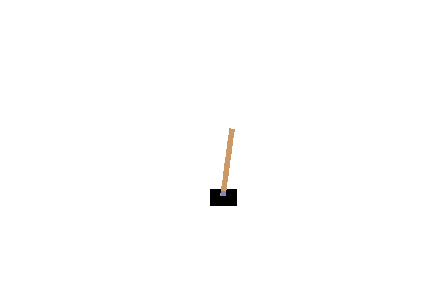
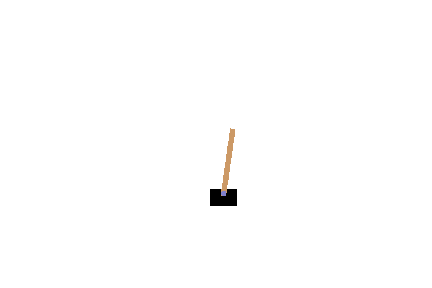
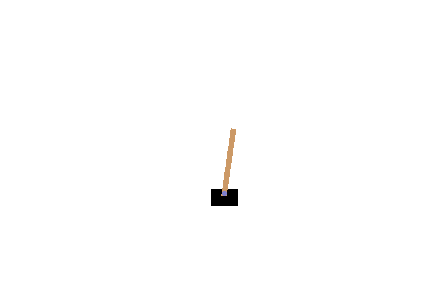
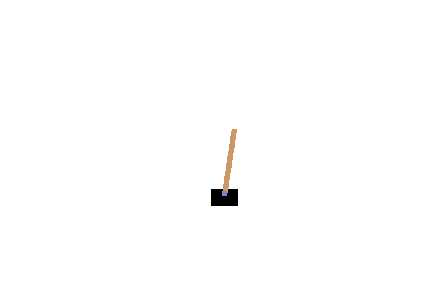
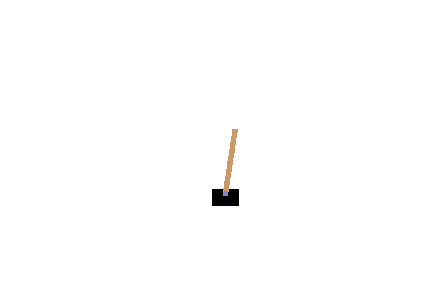
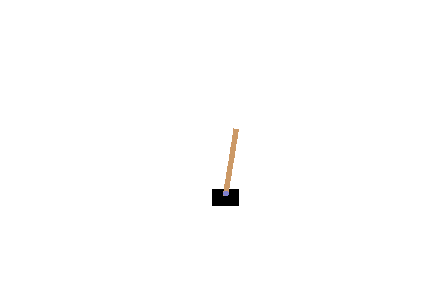
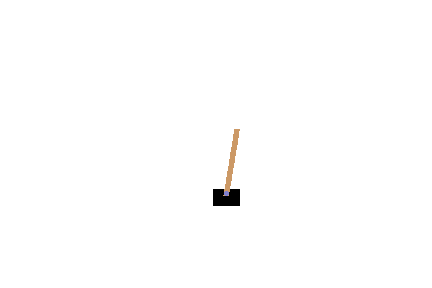
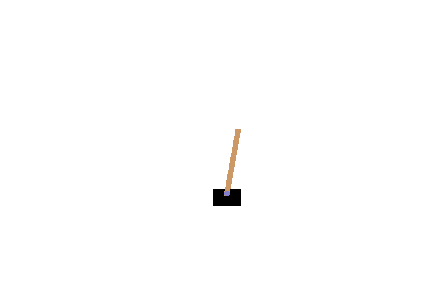
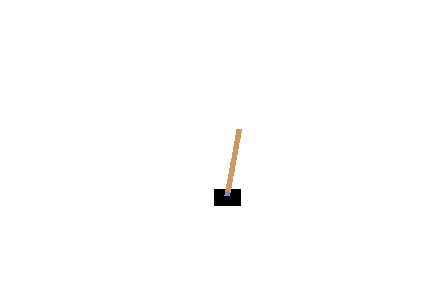
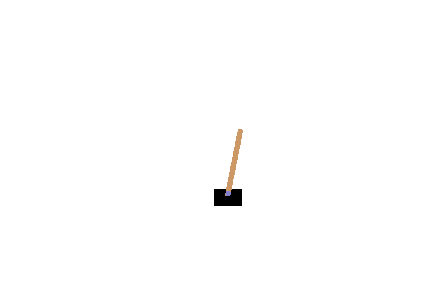
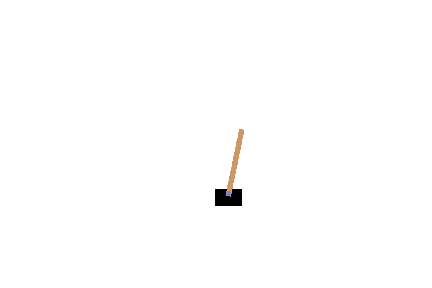
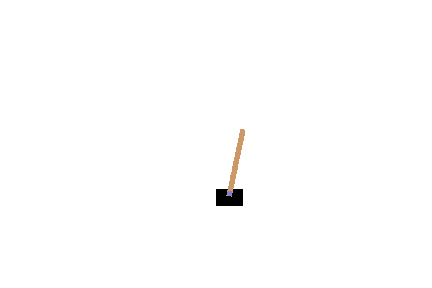
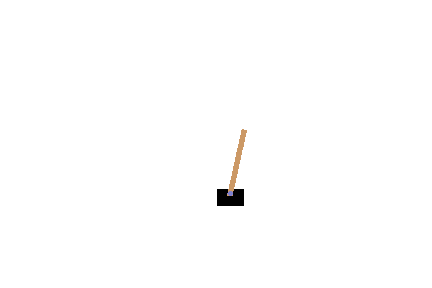

(56.0, 0.1)

In [26]:
run_episode(cartpole_env, simple_dqn, render=True)

In [27]:
"""
Target Network Parameters
"""
target_decay = 0.99

In [33]:
class TargetDQN(DQN):
    def __init__(self):
        self.target = self.build_dqn()
        super(TargetDQN, self).__init__()
        
    def train(self):
        super(TargetDQN, self).train()
        self.update_target()
        
    def update_target(self):
        model_weights = self.model.get_weights()
        target_weights = self.target.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.target_decay * target_weights[i] + \
                                (1 - target_decay) * model_weights[i]
        self.target.set_weights(target_weights)
    
    def target_predict(self, s):
        return self.model.predict(s)

In [34]:
better_dqn = TargetDQN()

In [35]:
warmup_buffer(cartpole_env, better_dqn)
eps = epsilon_init
sum_reward = 0
for episode in range(1, episodes+1):
    r, eps = run_episode(cartpole_env, better_dqn, epsilon=eps,
                         training=True, render=False)
    sum_reward += r
    if episode % 10 == 0:
        avg = sum_reward / 10
        sum_reward = 0
        start = episode - 9
        print("Average total reward for episode " + \
              f"{start} through {episode}: {avg}")

Average total reward for episode 1 through 10: 21.2
Average total reward for episode 11 through 20: 24.3
Average total reward for episode 21 through 30: 18.0
Average total reward for episode 31 through 40: 27.3
Average total reward for episode 41 through 50: 21.0
Average total reward for episode 51 through 60: 22.5
Average total reward for episode 61 through 70: 21.4
Average total reward for episode 71 through 80: 16.3
Average total reward for episode 81 through 90: 20.4
Average total reward for episode 91 through 100: 22.1
Average total reward for episode 101 through 110: 15.6
Average total reward for episode 111 through 120: 16.1
Average total reward for episode 121 through 130: 18.0
Average total reward for episode 131 through 140: 20.6
Average total reward for episode 141 through 150: 18.8
Average total reward for episode 151 through 160: 15.7
Average total reward for episode 161 through 170: 16.0
Average total reward for episode 171 through 180: 21.4
Average total reward for episo


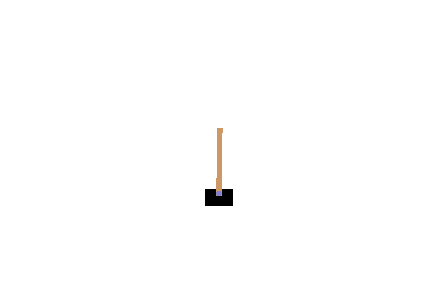
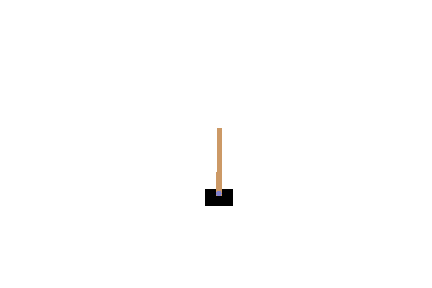
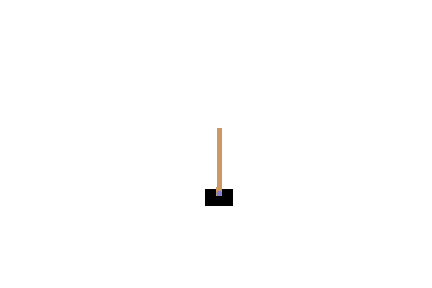
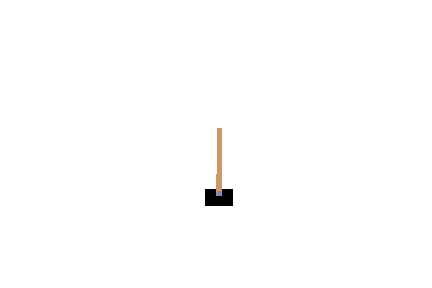
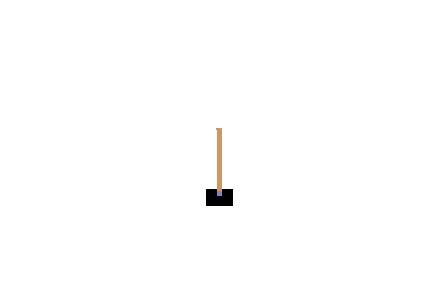
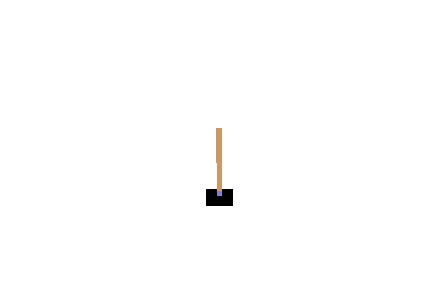
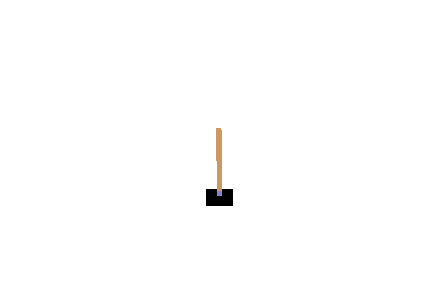
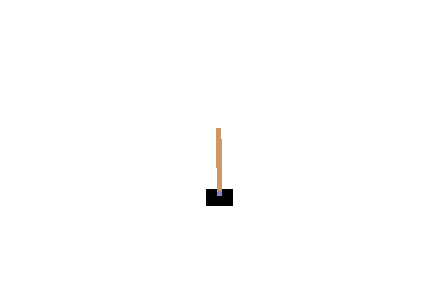
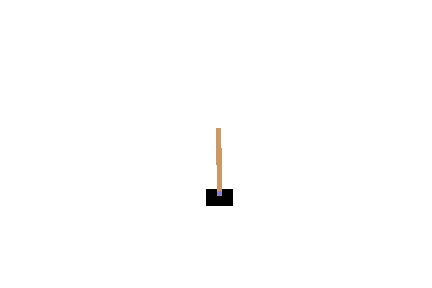
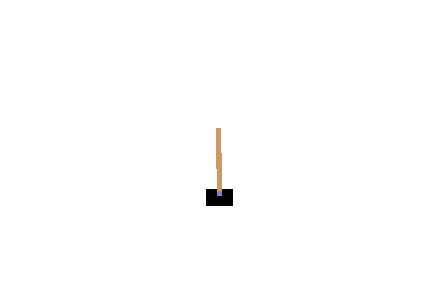
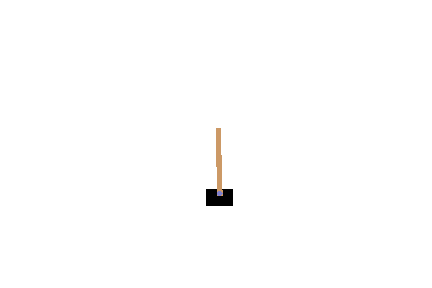
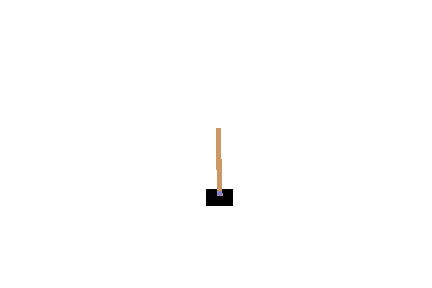
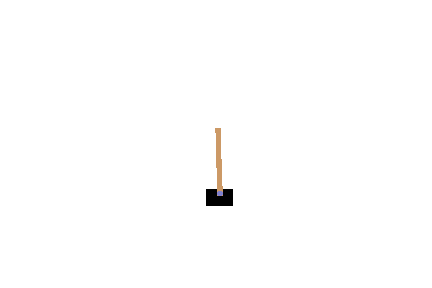
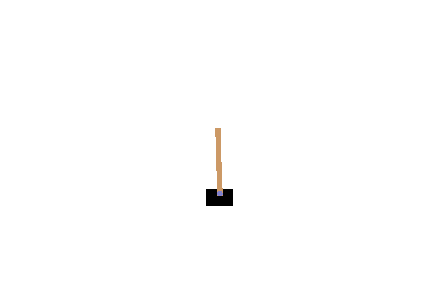
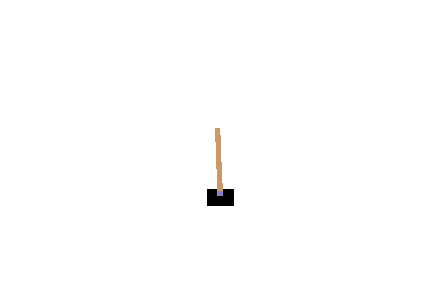
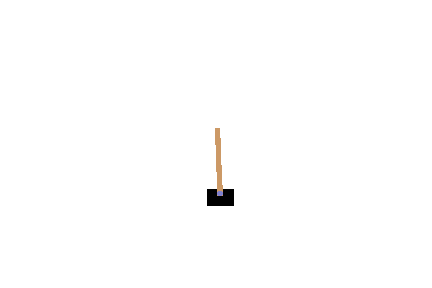
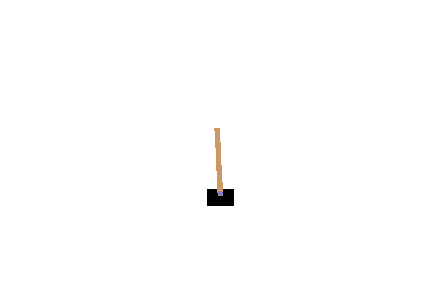
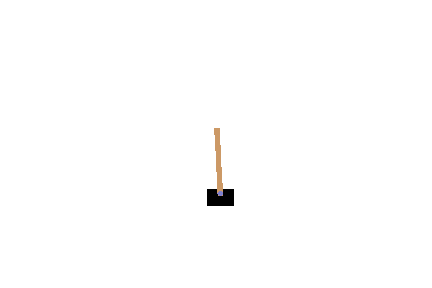
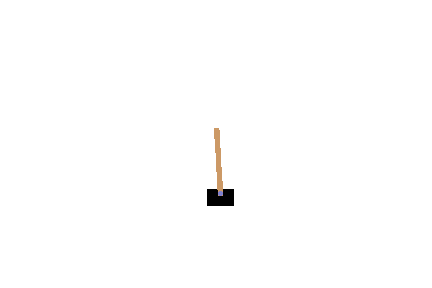
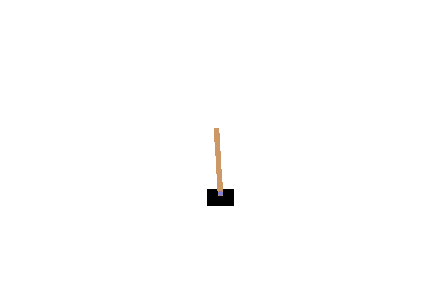
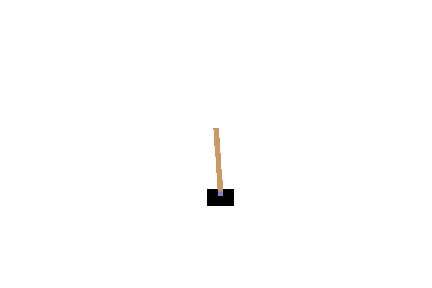
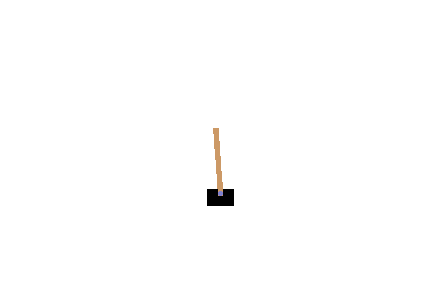
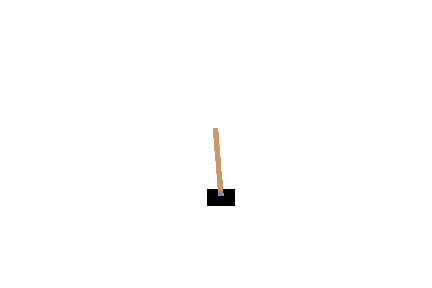
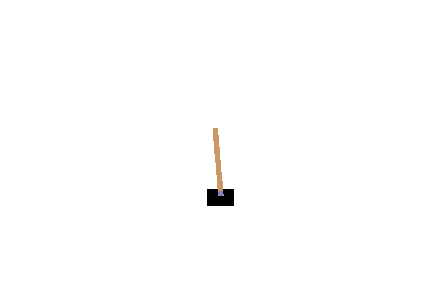
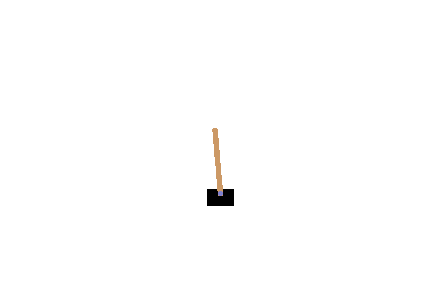
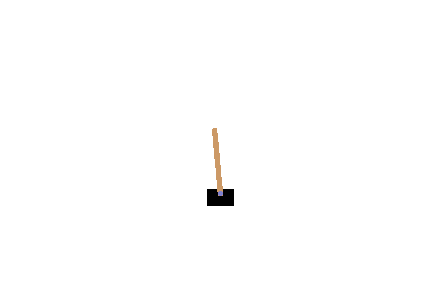
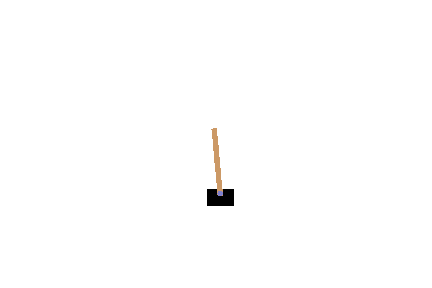
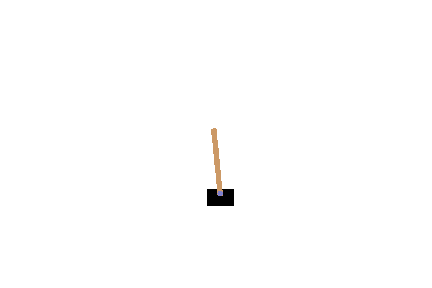
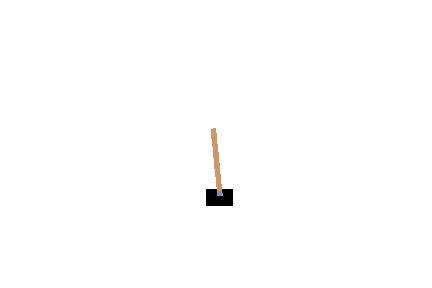
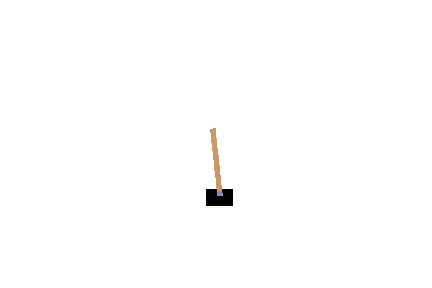
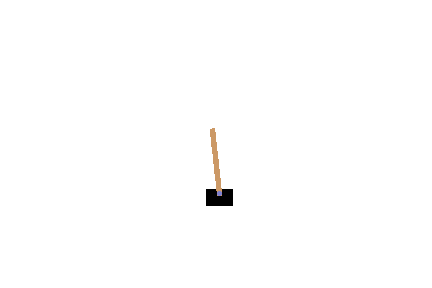
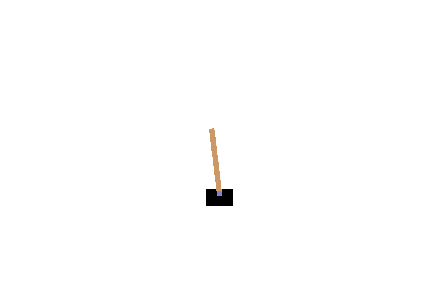
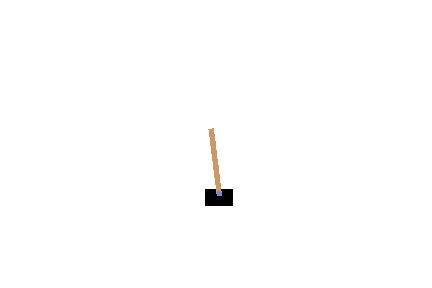
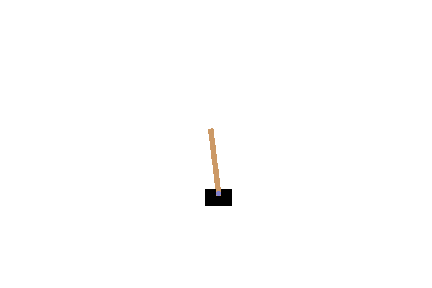
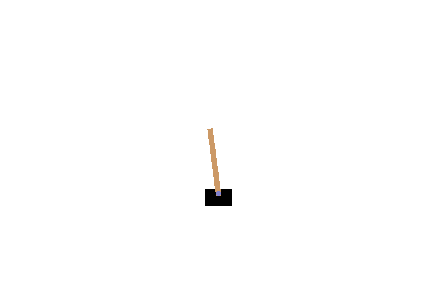
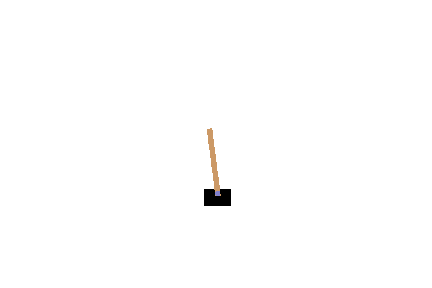
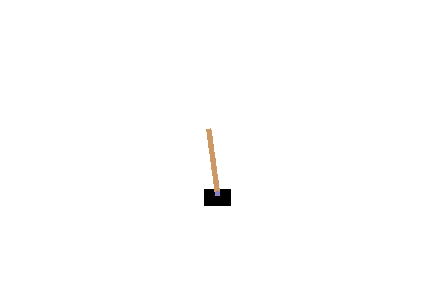
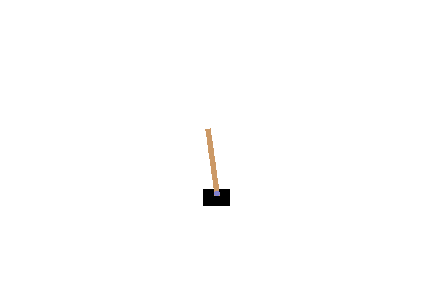
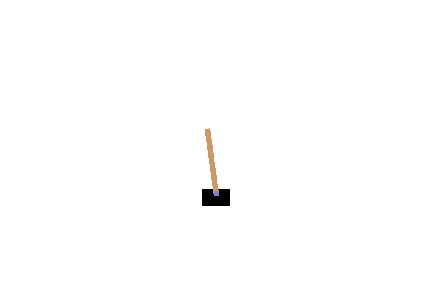
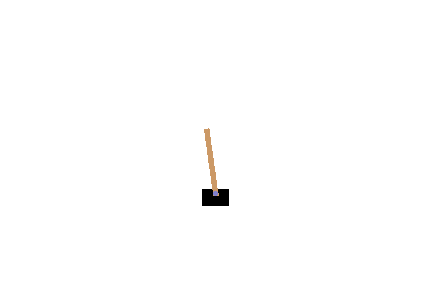
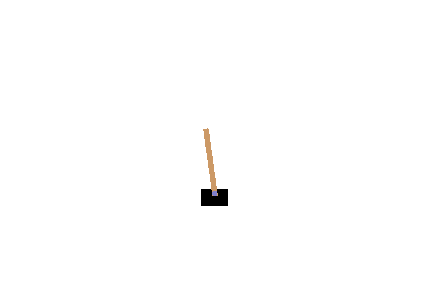
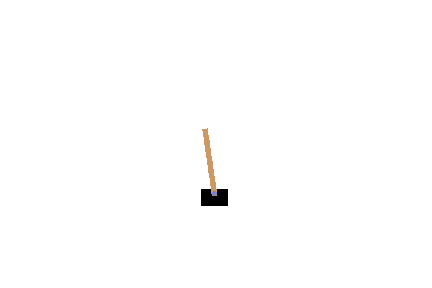
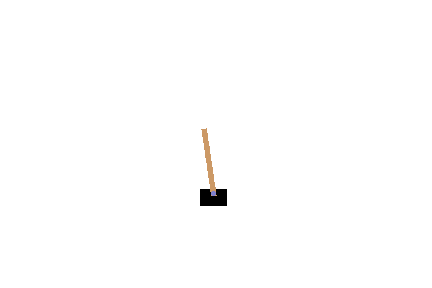
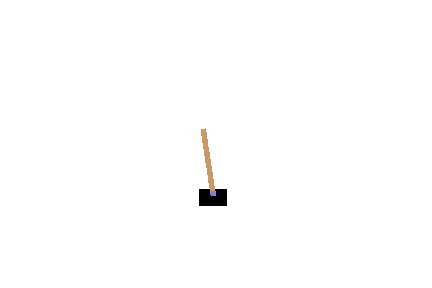
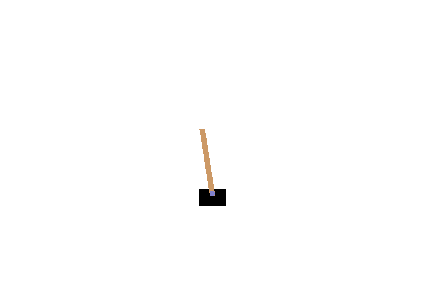
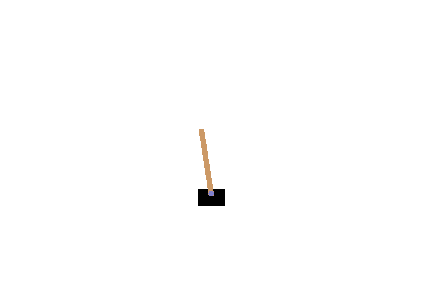
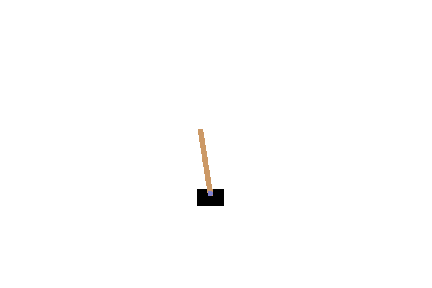
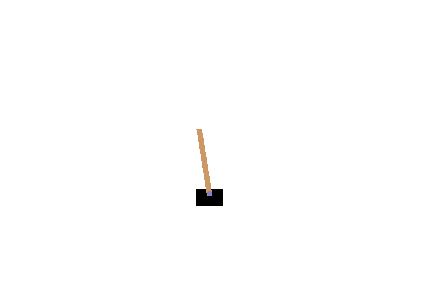
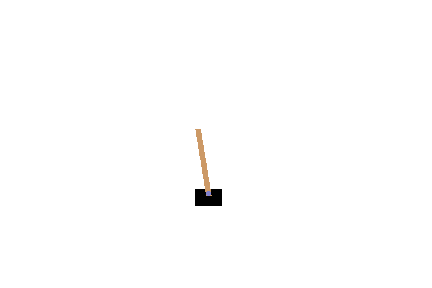
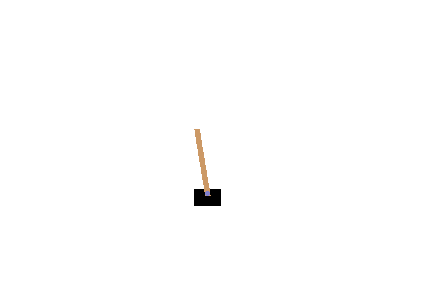
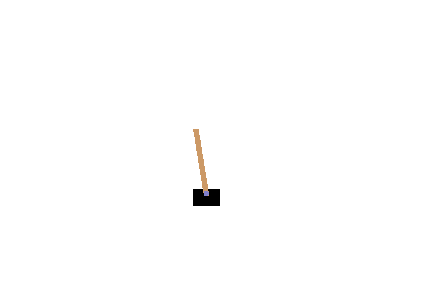
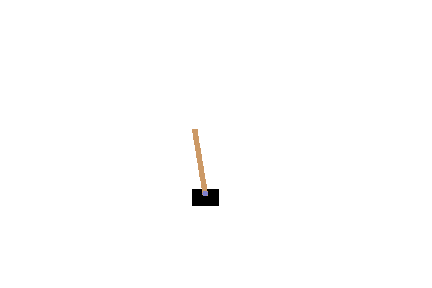
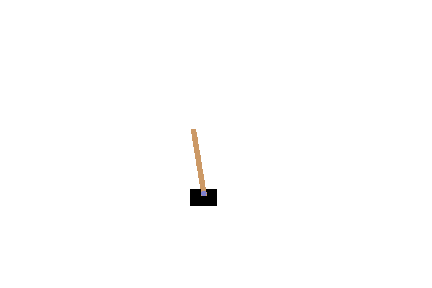
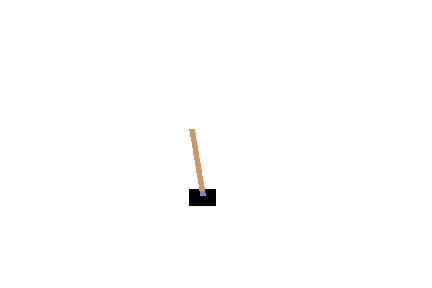
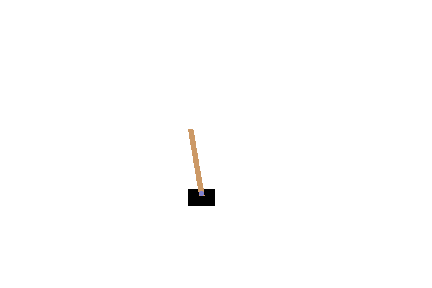
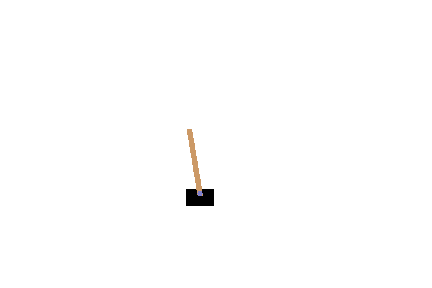
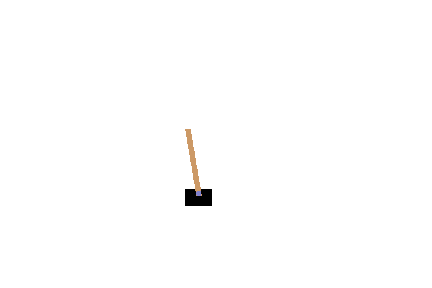
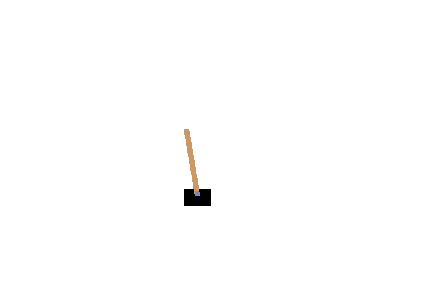
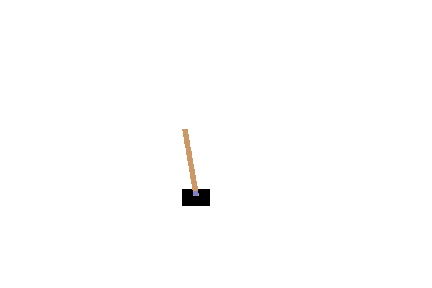
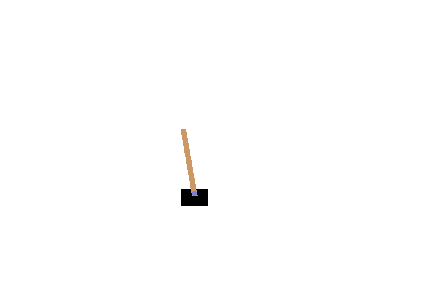
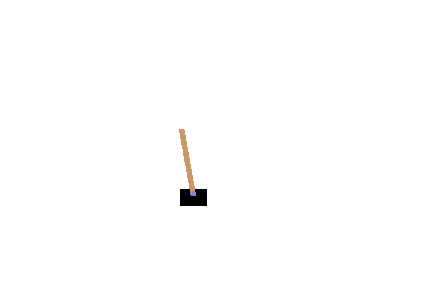
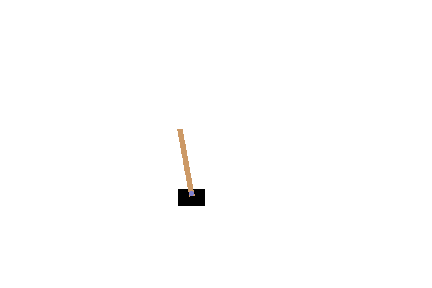
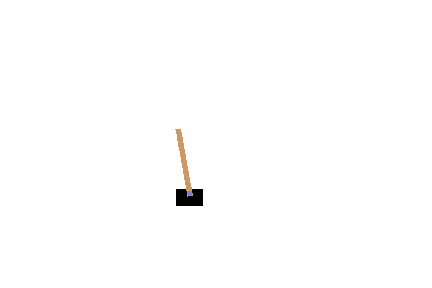
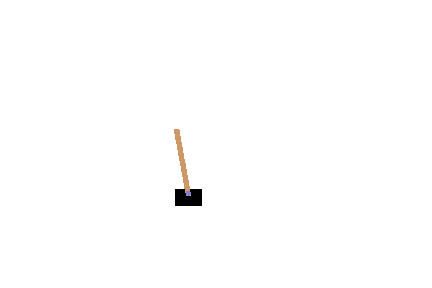
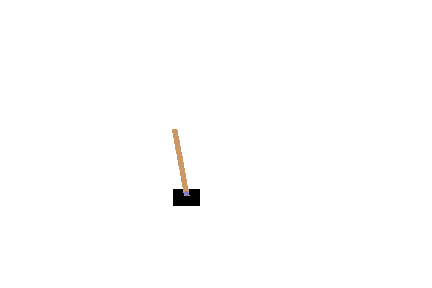
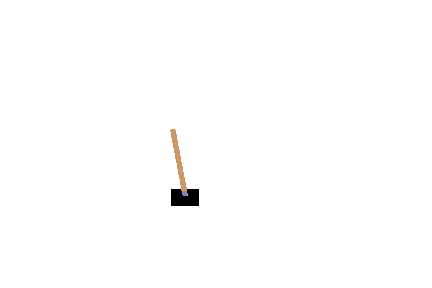
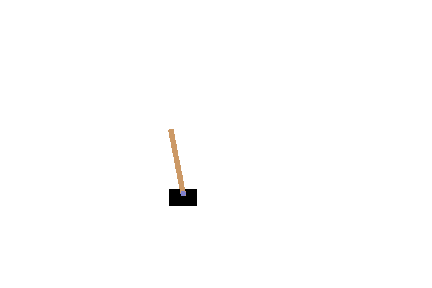
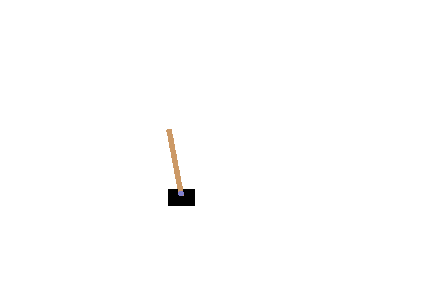
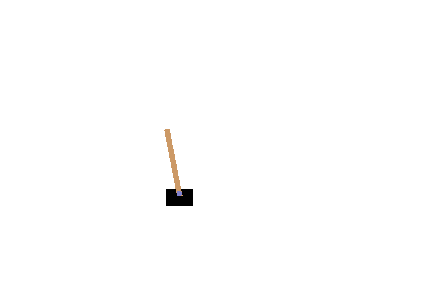
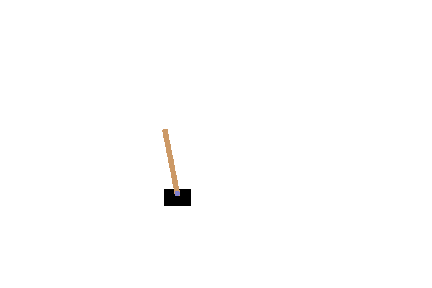
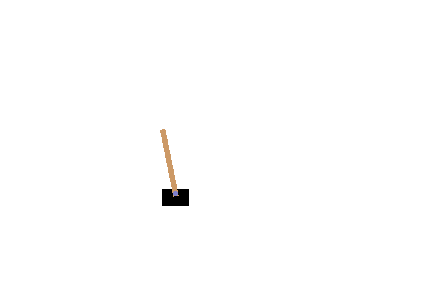
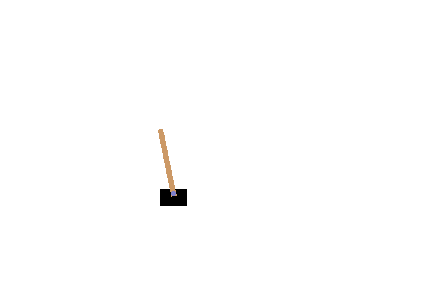
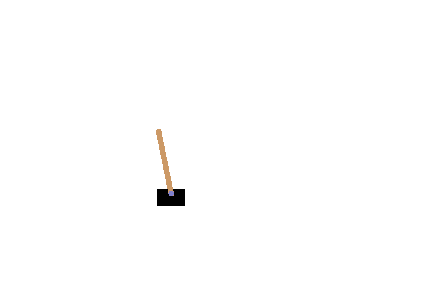
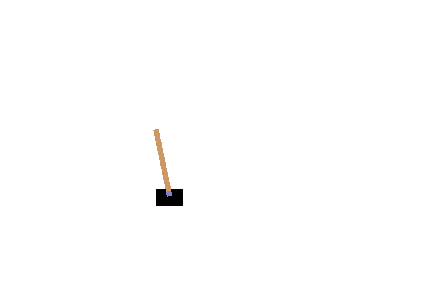
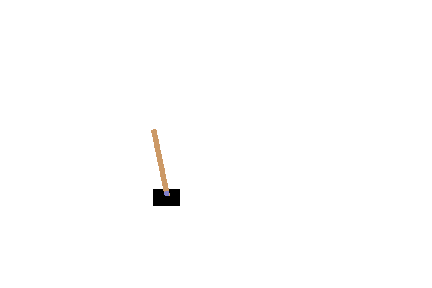
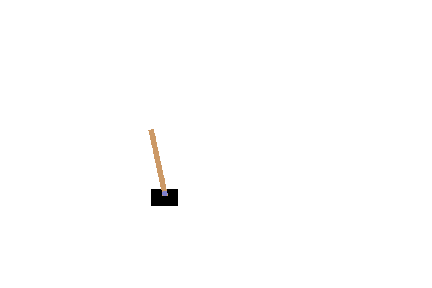

(75.0, 0.1)

In [37]:
run_episode(cartpole_env, better_dqn, render=True)